### Case 2 - Computational Data Analysis

#### UTKFaces dataset:

We use the clean version of the data (cropped and aligned) as given in the provided 'data.zip' file. 

- Faces: contains 23705 aligned and cropped images of shape (200 x 200 x 3) i.e. (Height x Width x Channel).
- labels.csv: labels of the images in the same order as the images in the 'Faces' folder; given in comma separated format as: age, gender, race.
- filenames.txt: original filenames of the images in the same order as the images and the labels.

#### Usual imports:

In [2]:
import os
import numpy as np
import skimage
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import numpy.linalg as linalg
import cmath
from skimage.io import imread,imshow
from skimage.color import rgb2gray 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

#### Upload data:

<font color='red'> I get MemoryError so I am working with a smaller dataset of 5000 images </font>

In [3]:
# Upload all images in a multidimensional array (Number of images x Height x Width x Channels):

path_faces = '/Users/Miren/COMPUTATIONAL DATA ANALYSIS/CASE 2/Faces/'
path_labels = '/Users/Miren/COMPUTATIONAL DATA ANALYSIS/CASE 2/labels.csv'

def load_images(folder):
    images = []
    # n_imgs = len(os.listdir(folder))  
    n_imgs = 5000
    for filename in range(n_imgs):
        img = mpimg.imread(os.path.join(folder, str(filename)+'.jpg'))
        if img is not None:
            images.append(img)
    return images

dataimgs = np.array(load_images(path_faces))
    
# labels on 'age', 'gender', and 'race' diven for each image. 

labels = pd.read_csv(path_labels,names=['age','gender','race'])

# We do not need the information in 'filenames.txt'

In [4]:
print(labels)

       age  gender  race
0      100       0     0
1      100       0     0
2      100       1     0
3      100       1     0
4      100       1     0
...    ...     ...   ...
23700    9       1     3
23701    9       1     3
23702    9       1     4
23703    9       1     4
23704    9       1     4

[23705 rows x 3 columns]


In [5]:
n_imgs = dataimgs.shape[0]
height = dataimgs.shape[1]
width = dataimgs.shape[2]
channels = dataimgs.shape[3]

print("Number of images: ",n_imgs)
print("Height: ", height)
print("Width: ", width)
print("Number of channels: ", channels)

Number of images:  5000
Height:  200
Width:  200
Number of channels:  3


Our objective would be to classify the images with the data features that have been reduced by PCA or LDA. Then, we can use K-Nearest Neighbors (KNN) algorithm to classify the image classes. 

### PCA

PCA IS UNSUPERVISED LEARNING

When performing PCA on images, we need to construct a 'flat' vactor of features, where the intensity of every pixel of an image is a feature (i.e. each image is represented as a vector instead of as a matrix). There should be no problem on using a RGB image in PCA by creating a vector of 200x200x3 features for each image, but for now, we decided to work in grayscale to reduce the dimensions of the problem and avoid MemoryErrors.

In [6]:
graydata = rgb2gray(dataimgs)

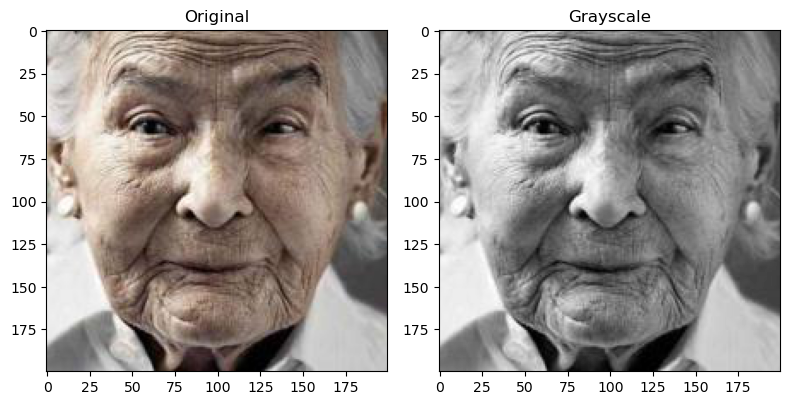

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(dataimgs[9])
ax[0].set_title("Original")
ax[1].imshow(graydata[9], cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

In [8]:
# Flatten the data: 
images = np.reshape(graydata, (n_imgs, height * width))

The idea of PCA consists on a linear transformation of data: S = XL; where we find an orthogonal transformation by the L rotation matrix over the data X, obtaining the transformed data S (score matrix) which will have maximum variance (i.e., minimum mean square error (MSE)).

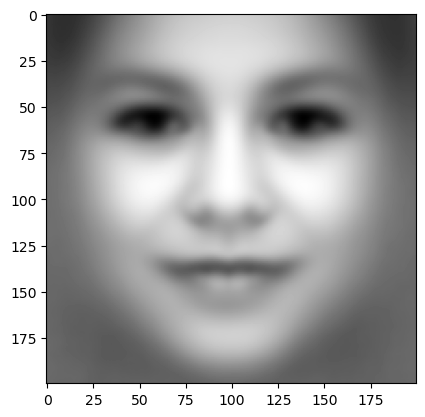

In [9]:
# mean of the data: 
img_mean = np.mean(images, axis = 0)
plt.imshow(np.reshape(img_mean,(height,width)), cmap = "gray")
plt.show()

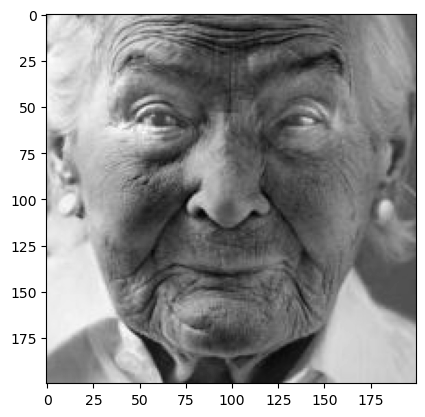

In [10]:
# Center the data (substract mean)
centered_imgs = images - img_mean
plt.imshow(np.reshape(centered_imgs[9],(height,width)), cmap = "gray")
plt.show()

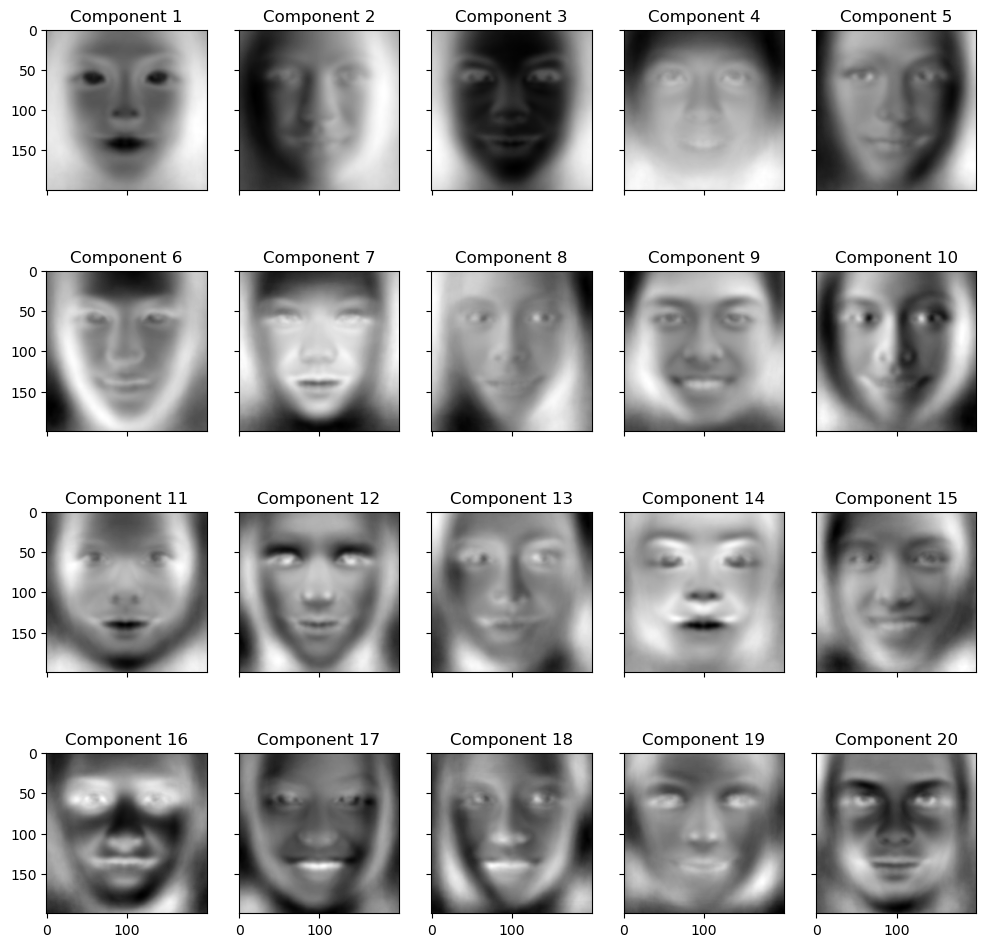

In [10]:
n_features = height*width  # n_components must be between 0 and min(n_samples, n_features)=5000 with svd_solver='full'
n_components = 200 # min(5000, n_features) # We could start with a smaller number of features too. 
pca = PCA(n_components=n_components)
S = pca.fit_transform(centered_imgs)
A = pca.components_

# Visually inspect the first 20 PCA components as images:
img_plot = np.reshape(A, (n_components, height, width))

f, axs = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in zip(range(20), axs):
    ax.imshow(img_plot[i,:,:], cmap ='gray')
    ax.set_title('Component ' + str(i+1))
plt.show()

Now we can reconstruct the images with just the number of PCs we are interested in. We can choose this number by defining the certain percentage of explained variance we want to obtain (i.e., 95%) or by making a scree plot, which is the recomended method, and consists on comparing the eigenvalues to those obtained from dantomized data (with same total variance). 

##### Obtain a certain percentage of explained variance

<font color='red'>Find the reason why the percentage of expl var is usually a bad idea (and decide if we keep both and explain or just keep one)</font>

In [11]:
ratio_var = pca.explained_variance_ratio_
var_cumu = np.cumsum(ratio_var)
d=np.argmax(var_cumu>=0.95)+1

print("Number of components explaining 95% variance: ", d)

Number of components explaining 95% variance:  167


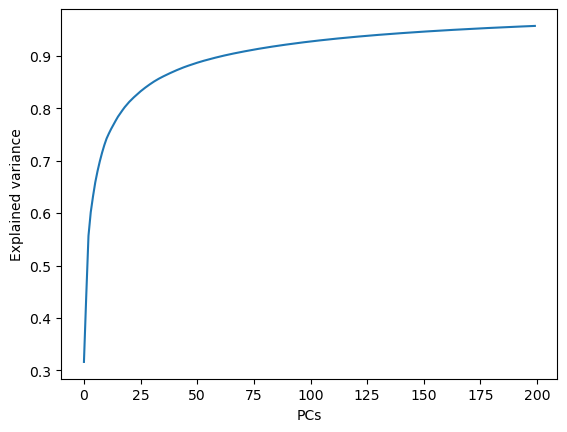

In [12]:
plt.plot(var_cumu);
plt.xlabel("PCs")
plt.ylabel("Explained variance")
plt.show()

In [13]:
images.shape

(5000, 40000)

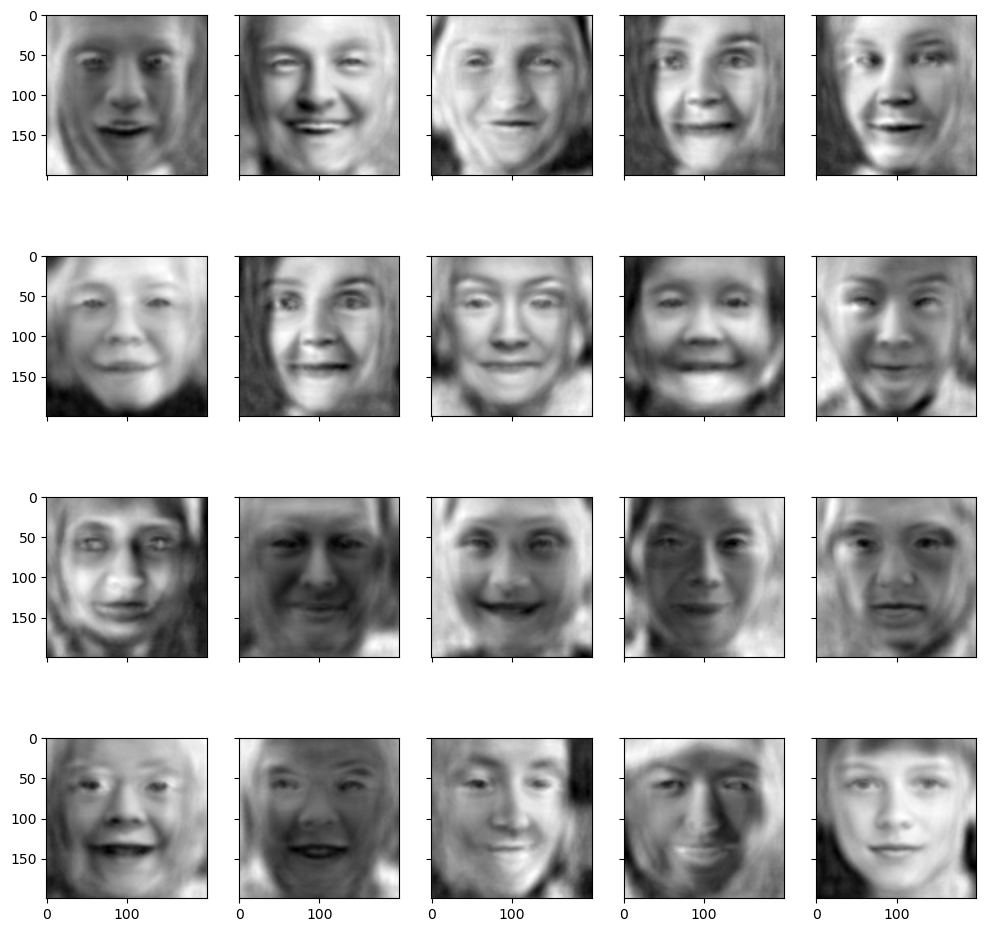

In [14]:
# Reconstruct the images using 167 components:
pca_red = PCA(n_components = d)
S_red = pca_red.fit_transform(centered_imgs)
A_red = pca_red.components_


# Visually inspect the reconstruction of the first 20 images in our dataset:
imgs_reconstr = np.matmul(S_red,A_red) + img_mean
img_plot = np.reshape(imgs_reconstr, (n_imgs, height, width))

f, axs = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in zip(range(20), axs):
    ax.imshow(img_plot[i,:,:], cmap ='gray')
plt.show()

<font color='red'> Seems like a bad reconstrucion, like too little PCs, but maybe it works well with this few PCs even if doesn't look so visually. When we run pca with many more components we get much better results visually (therefore, the plotting is okay). </font>

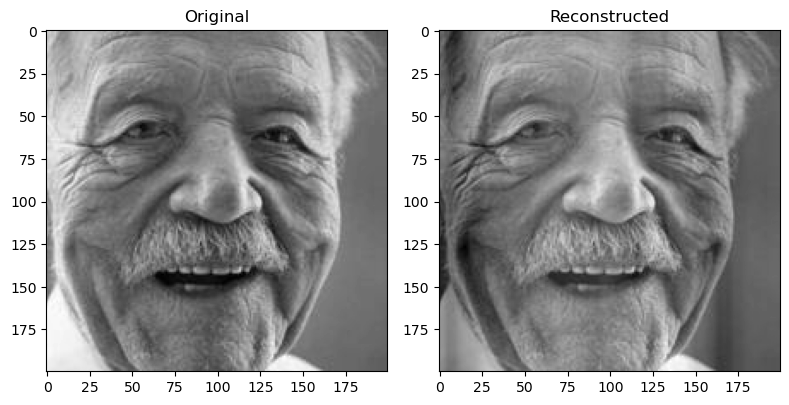

In [15]:
# PCA fitted in a single using 167 components:
pca_red_one = PCA(n_components = d)

S_red_one = pca_red_one.fit_transform(centered_imgs[0].reshape(200,200))
A_red_one = pca_red_one.components_

# Visually inspect the reconstruction of the first 20 images in our dataset:
img_plot = np.matmul(S_red_one,A_red_one) + img_mean.reshape(200,200)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(images[0].reshape(200,200), cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[1].imshow(img_plot, cmap=plt.cm.gray)
ax[1].set_title("Reconstructed")

fig.tight_layout()
plt.show()

#### Using a scree plot

In [16]:
#Artificial data set
#Dimensions of data 5000 X 200 x 200 

art_var = np.var(graydata)
art_mean = np.mean(graydata)

a, b = 0, 1
mu, sigma = art_mean, art_var
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

randomdata = []

for i in range(5000):
    randomdata.append([])
    for j in range(200):
        randomdata[i].append(dist.rvs(200))
        
rnd_baseline=linalg.eig(randomdata)

/Users/Miren/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


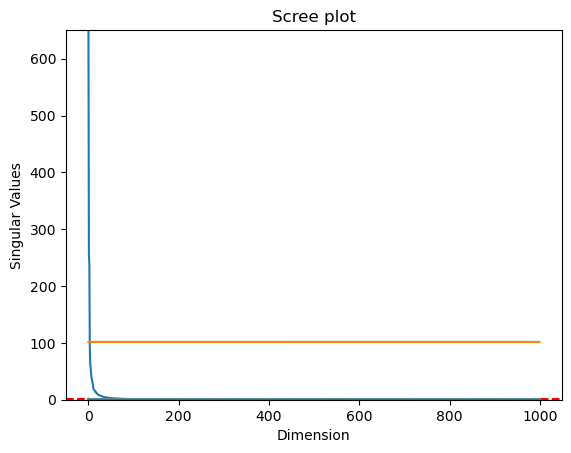

(101.62949042841615+0j)
(101.69848877198474+0j)
(101.62594119614624+0j)
(101.70184794357186+0j)
(101.7244614998545+0j)
(101.63201575208674+0j)
(101.64712801999313+0j)
(101.71231792721287+0j)
(101.62919503346912+0j)
(101.65455592218557+0j)
(101.67195662058948+0j)
(101.63831312922417+0j)
(101.64275512063074+0j)
(101.65493390317097+0j)
(101.70208567292336+0j)
(101.58545198511906+0j)
(101.68451742280034+0j)
(101.70426161442218+0j)
(101.71035811015497+0j)
(101.60286178729346+0j)


In [17]:
plt.ylabel('Singular Values')
plt.xlabel('Dimension')
plt.title('Scree plot')
plt.ylim(0, max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.plot(rnd_baseline[0][:1000])
plt.show()
#print(len(rnd_baseline[0]))
for i in range(20):
    print(rnd_baseline[0][i][0])
    #print(rnd_baseline[1][i])

/Users/Miren/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


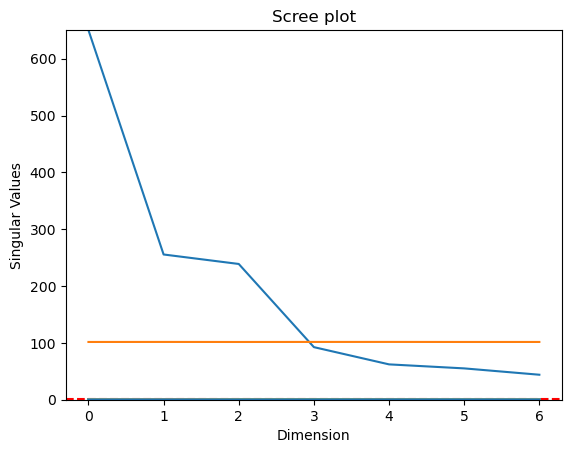

In [18]:
plt.ylabel('Singular Values')
plt.xlabel('Dimension')
plt.title('Scree plot')
plt.ylim(0, max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle = '--')
plt.plot(pca.explained_variance_[:7])
plt.plot(rnd_baseline[0][:7])
plt.show()

<font color='red'> Wich sets the number of components of interest in 3 PCs.</font>

For now, we have done dimensionality reduction using PCA. 

Now we will try to use KNN algorithm to classify the image classes by 'gender' first. For that we will split our dataset <font color='red'> (that has just 5000 images for now) </font> into training set <font color='red'> (4000 images for now) </font> and test set <font color='red'> (the remaining 1000 images)</font>. We will try KNN for 3 cases: 167 components as stated in the case of obtaining more than 95% of explained variance, 3 components as result of observing the scree plot, and 1000 componens as the case of too good reconstructions. 

In [19]:
# Split into train and test datasets: 
idxs_train = random.sample(range(5000), 4000)
idxs_test = [i for i in range(5000) if i not in idxs_train]

gender_train = labels['gender'][idxs_train]
gender_test = labels['gender'][idxs_test].reset_index(drop=True)

race_train = labels['race'][idxs_train]
race_test = labels['race'][idxs_test].reset_index(drop=True)

# PCA

for n_components in [1000, d, 3]:
    imgs_train = centered_imgs[idxs_train]
    imgs_test = centered_imgs[idxs_test]
    
    print('____________________________ \n')
    print('Case 1. Number of components = ', n_components)
    n_features = height*width  # n_components must be between 0 and min(n_samples, n_features)=5000 with svd_solver='full'
    pca = PCA(n_components=n_components)
    imgs_train = pca.fit_transform(imgs_train)
    imgs_test = pca.fit_transform(imgs_test)

    k = 5
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    knn_model.fit(imgs_train, gender_train) 
    gender_predict = knn_model.predict(imgs_test)

    knn_model.fit(imgs_train, race_train) 
    race_predict = knn_model.predict(imgs_test)

    count_genre = 0
    count_race = 0

    for i in range(1000):
        if gender_test[i]==gender_predict[i]:
            count_genre += 1
        if race_test[i]==race_predict[i]:
            count_race +=1

    accuracy_genre = count_genre/1000
    accuracy_race = count_race/1000

    print('Accuracy_genre = ', accuracy_genre)
    print('Accuracy_race = ', accuracy_race)

____________________________ 

Case 1. Number of components =  1000
Accuracy_genre =  0.528
Accuracy_race =  0.308
____________________________ 

Case 1. Number of components =  167
Accuracy_genre =  0.528
Accuracy_race =  0.298
____________________________ 

Case 1. Number of components =  3
Accuracy_genre =  0.474
Accuracy_race =  0.29


<font color='red'> The accuracy did not change too much between each case, that's a good thing I suppose, because it would mean that from 3 components we are getting almost as same useful information than from 167 and from 1000, right? </font>.

### LDA

LDA IS SUPERVISED LEARNING

In Linear Discriminant Analysis (LDA) instead of maximizing the variance, we will minimize the variance and find the axes that maximize the separation between the class mean.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

idxs_train = random.sample(range(5000), 4000)
idxs_test = [i for i in range(5000) if i not in idxs_train]

gender_train = labels['gender'][idxs_train]
gender_test = labels['gender'][idxs_test].reset_index(drop=True)

race_train = labels['race'][idxs_train]
race_test = labels['race'][idxs_test].reset_index(drop=True)

imgs_train = centered_imgs[idxs_train]
imgs_test = centered_imgs[idxs_test]

n_features = height*width 
lda = LinearDiscriminantAnalysis(n_components=None)  #n_components = min(n_classes - 1, n_features)

Number of components explaining 95% variance:  1


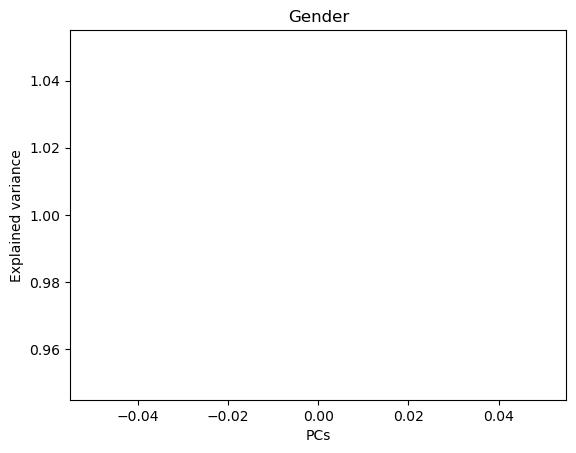

In [14]:
#genre
imgs_train_gender = lda.fit_transform(imgs_train, gender_train)
imgs_test_gender = lda.transform(imgs_test)

lda_var_ratios = lda.explained_variance_ratio_
var_cumu = np.cumsum(lda_var_ratios)
d_gender=np.argmax(var_cumu>=0.95)+1

print("Number of components explaining 95% variance: ", d_gender)

plt.plot(var_cumu);
plt.title('Gender')
plt.xlabel("PCs")
plt.ylabel("Explained variance")
plt.show()

In [15]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(imgs_train_gender, gender_train) 
gender_predict = knn_model.predict(imgs_test_gender)

count_gender= 0

for i in range(1000):
    if gender_test[i]==gender_predict[i]:
        count_gender +=1
        
accuracy_gender = count_gender/1000

print('Accuracy_race = ', accuracy_gender)

Accuracy_race =  0.663


Number of components explaining 95% variance:  3


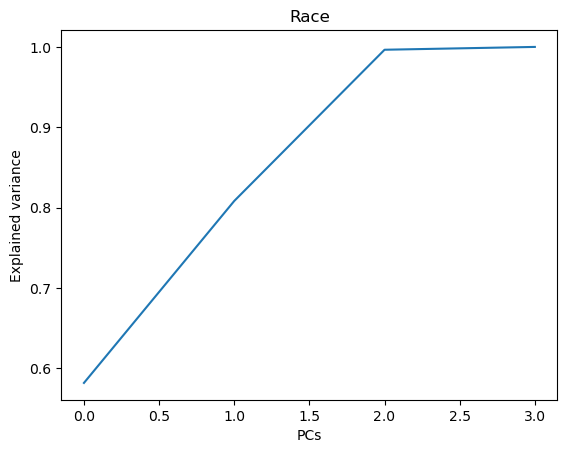

In [16]:
#race
imgs_train_race = lda.fit_transform(imgs_train, race_train)
imgs_test_race = lda.transform(imgs_test)

lda_var_ratios = lda.explained_variance_ratio_
var_cumu = np.cumsum(lda_var_ratios)
d_race=np.argmax(var_cumu>=0.95)+1

print("Number of components explaining 95% variance: ", d_race)

plt.plot(var_cumu);
plt.title('Race')
plt.xlabel("PCs")
plt.ylabel("Explained variance")
plt.show()

In [17]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(imgs_train_race, race_train) 
race_predict = knn_model.predict(imgs_test_race)

count_race = 0

for i in range(1000):
    if race_test[i]==race_predict[i]:
        count_race +=1
        
accuracy_race = count_race/1000

print('Accuracy_race = ', accuracy_race)

Accuracy_race =  0.415


https://benalexkeen.com/k-nearest-neighbours-classification-in-python/
https://www.linkedin.com/pulse/dimensionality-reduction-pca-vs-lda-face-recognition-m-farhan-tandia